In [50]:
import pandas as pd
import numpy as np
from rapidfuzz import process, fuzz
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_rel

df_imdb = pd.read_csv("cleaned_imdb.csv")
df_imdb.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,aka_title,region,language,log_numVotes,runtime_winsorized
0,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0,Al otro lado del viento,AR,Unknown,8.415825,122.0
1,tt0249516,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248.0,A Guerra das Comidas,BR,Unknown,9.017847,91.0
2,tt0293069,Dark Blood,2012,86.0,Thriller,6.6,1053.0,Dark Blood,Unknown,Unknown,6.960348,86.0
3,tt0315642,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378.0,64 Squares,Unknown,Unknown,9.640758,103.0
4,tt0323808,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328.0,Cowboys for Christ,GB,Unknown,7.753194,96.0


In [51]:
df_tmdb = pd.read_csv("cleaned_tmdb.csv")
df_tmdb.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,title,vote_average,vote_count,release_year,log_popularity
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,2010,3.541915
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,How to Train Your Dragon,7.7,7610,2010,3.392291
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,Iron Man 2,6.8,12368,2010,3.384899
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,Toy Story,7.9,10174,1995,3.367468
4,4,"[28, 878, 12]",27205,en,Inception,27.920,Inception,8.3,22186,2010,3.364533


In [52]:
#Work with the same time period between the two dataframes. Using 2010-2020 since the IMDB data is only dated within that
imdb_df = df_imdb[(df_imdb['start_year'] >= 2010) & (df_imdb['start_year'] <= 2020)]
tmdb_df = df_tmdb[(df_tmdb['release_year'] >= 2010) & (df_tmdb['release_year'] <= 2020)]

In [53]:
#Checking comparison between the ratings and people who voted

print("IMDB ratings summary:")
print(imdb_df['averagerating'].describe())
print("\nTMDB ratings summary:")
print(tmdb_df['vote_average'].describe())

print("\nIMDB votes summary:")
print(imdb_df['numvotes'].describe())
print("\nTMDB votes summary:")
print(tmdb_df['vote_count'].describe())

IMDB ratings summary:
count    9617.000000
mean        6.248778
std         1.158872
min         1.200000
25%         5.600000
50%         6.400000
75%         7.100000
max         9.700000
Name: averagerating, dtype: float64

TMDB ratings summary:
count    25288.000000
mean         5.974779
std          1.869167
min          0.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         10.000000
Name: vote_average, dtype: float64

IMDB votes summary:
count    9.617000e+03
mean     2.625648e+04
std      8.033737e+04
min      1.000000e+03
25%      1.654000e+03
50%      3.464000e+03
75%      1.214300e+04
max      1.841066e+06
Name: numvotes, dtype: float64

TMDB votes summary:
count    25288.000000
mean       172.995452
std        895.085139
min          1.000000
25%          1.000000
50%          5.000000
75%         25.000000
max      22186.000000
Name: vote_count, dtype: float64


In [54]:
# Quick exact title join using the titles for initial corelation checks
merged_check = pd.merge(imdb_df, tmdb_df, left_on="primary_title", right_on="title", how="inner")

# Correlation between IMDB and TMDB ratings
print("Correlation (IMDB vs TMDB ratings):")
print(merged_check[['averagerating', 'vote_average']].corr())

Correlation (IMDB vs TMDB ratings):
               averagerating  vote_average
averagerating       1.000000      0.706779
vote_average        0.706779      1.000000


In [55]:
#High correlation between the ratings i.e when IMDB ratings are high, the corresponding TMDB ratings are high as well

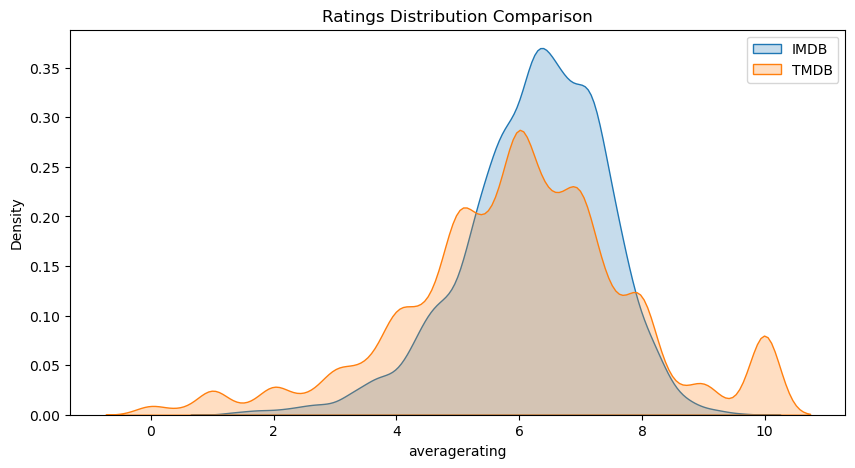

In [56]:

plt.figure(figsize=(10,5))
sns.kdeplot(imdb_df['averagerating'], label="IMDB", fill=True)
sns.kdeplot(tmdb_df['vote_average'], label="TMDB", fill=True)
plt.legend()
plt.title("Ratings Distribution Comparison")
plt.show()

In [57]:
#Use fuzzy match to compare titles

# Create a dictionary mapping imdb_title -> best tmdb_title
title_map = {}

tmdb_titles = tmdb_df['title'].tolist()

for imdb_title in imdb_df['primary_title']:
    match, score, idx = process.extractOne(
        imdb_title, tmdb_titles, scorer=fuzz.token_sort_ratio
    )
    if score >= 85:  # threshold (0-100), adjust if too strict/loose
        title_map[imdb_title] = match


imdb_df['tmdb_match'] = imdb_df['primary_title'].map(title_map)

# Merge on imdb.primary_title -> tmdb.title
combined_df = imdb_df.merge(
    tmdb_df,
    left_on='tmdb_match',
    right_on='title',
    how='inner',
    suffixes=('_imdb','_tmdb')
)

In [58]:
#Check combined movies

print("Matched:", len(combined_df))
print("Unmatched IMDB:", imdb_df['primary_title'].nunique() - len(combined_df))
combined_df[['primary_title','title','averagerating','vote_average','popularity']].head()

Matched: 7103
Unmatched IMDB: 2346


,primary_title,title,averagerating,vote_average,popularity
0,The Other Side of the Wind,The Other Side of the Wind,6.9,7.0,9.800
1,Foodfight!,Foodfight!,1.9,2.1,4.705
2,Dark Blood,Dark Blood,6.6,6.1,1.721
3,Wazir,Wazir,7.1,6.6,3.881
4,The Wicker Tree,The Wicker Tree,3.9,4.4,2.962


In [59]:
combined_df.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,aka_title,region,language,...,genre_ids,id,original_language,original_title,popularity,title,vote_average,vote_count,release_year,log_popularity
0,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0,Al otro lado del viento,AR,Unknown,...,"[35, 18]",299782,en,The Other Side of the Wind,9.800,The Other Side of the Wind,7.0,64,2018,2.379546
1,tt0249516,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248.0,A Guerra das Comidas,BR,Unknown,...,"[16, 28, 35, 10751]",116977,en,Foodfight!,4.705,Foodfight!,2.1,46,2013,1.741343
2,tt0293069,Dark Blood,2012,86.0,Thriller,6.6,1053.0,Dark Blood,Unknown,Unknown,...,[53],136884,en,Dark Blood,1.721,Dark Blood,6.1,7,2013,1.000999
3,tt0315642,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378.0,64 Squares,Unknown,Unknown,...,"[53, 28, 80, 18, 9648]",275269,hi,वज़ीर,3.881,Wazir,6.6,63,2016,1.585350
4,tt0323808,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328.0,Cowboys for Christ,GB,Unknown,...,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,The Wicker Tree,4.4,25,2012,1.376749


In [60]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7103 entries, 0 to 7102
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            7103 non-null   object 
 1   primary_title       7103 non-null   object 
 2   start_year          7103 non-null   int64  
 3   runtime_minutes     7103 non-null   float64
 4   genres              7103 non-null   object 
 5   averagerating       7103 non-null   float64
 6   numvotes            7103 non-null   float64
 7   aka_title           7103 non-null   object 
 8   region              7103 non-null   object 
 9   language            7103 non-null   object 
 10  log_numVotes        7103 non-null   float64
 11  runtime_winsorized  7103 non-null   float64
 12  tmdb_match          7103 non-null   object 
 13  Unnamed: 0          7103 non-null   int64  
 14  genre_ids           7103 non-null   object 
 15  id                  7103 non-null   int64  
 16  origin

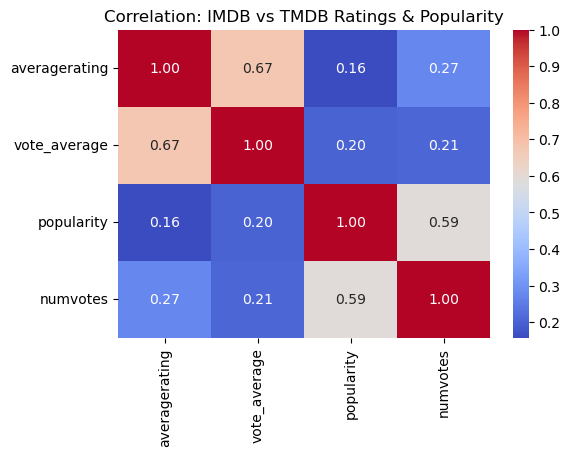

In [61]:
#Check correlation between the ratings and popularity
# Select relevant columns
corr_df = combined_df[['averagerating', 'vote_average', 'popularity','numvotes']]

# Correlation matrix
corr = corr_df.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: IMDB vs TMDB Ratings & Popularity")
plt.show()

In [62]:

# Model: IMDB rating ~ popularity
X1 = sm.add_constant(combined_df['popularity'])
y1 = combined_df['averagerating']
model1 = sm.OLS(y1, X1).fit()

print("IMDB Rating ~ Popularity")
print(model1.summary())

IMDB Rating ~ Popularity
                            OLS Regression Results                            
Dep. Variable:          averagerating   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     179.7
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           1.72e-40
Time:                        21:05:51   Log-Likelihood:                -10771.
No. Observations:                7103   AIC:                         2.155e+04
Df Residuals:                    7101   BIC:                         2.156e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9327      

In [63]:
# Model: TMDB rating ~ popularity
X2 = sm.add_constant(combined_df['popularity'])
y2 = combined_df['vote_average']
model2 = sm.OLS(y2, X2).fit()

print("\nTMDB Rating ~ Popularity")
print(model2.summary())


TMDB Rating ~ Popularity
                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     296.3
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           4.44e-65
Time:                        21:05:51   Log-Likelihood:                -11184.
No. Observations:                7103   AIC:                         2.237e+04
Df Residuals:                    7101   BIC:                         2.239e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7581     

In [64]:
t_stat, p_val = ttest_rel(combined_df['averagerating'], combined_df['vote_average'])
print(f"Paired t-test: t={t_stat:.3f}, p={p_val:.3g}") #Slice with 3f for 3 decimal places and 3g for all digits to account for the really small values

Paired t-test: t=9.050, p=1.82e-19


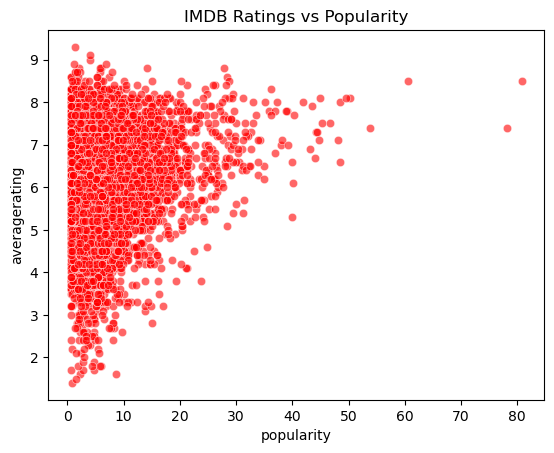

In [65]:
sns.scatterplot(x="popularity", y="averagerating", data=combined_df, alpha=0.6, color="red")
plt.title("IMDB Ratings vs Popularity")
plt.show()

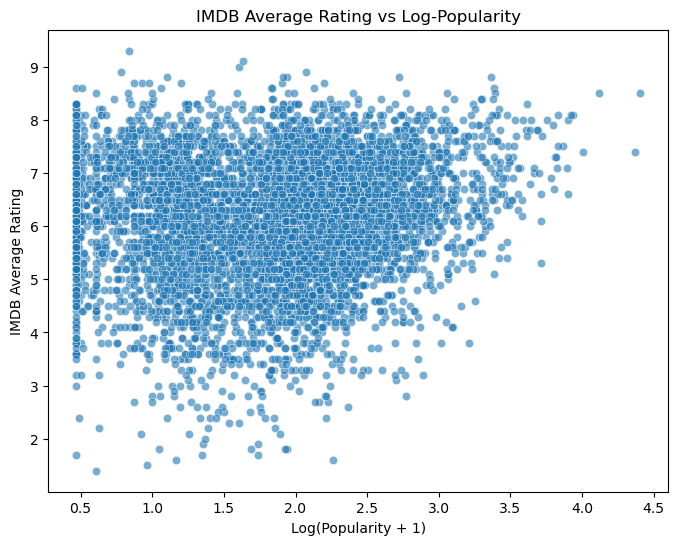

In [66]:
# Create log-transformed popularity
combined_df["log_popularity"] = np.log1p(combined_df["popularity"])  

# Scatter plot: ratings vs log-popularity
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=combined_df, 
    x="log_popularity", 
    y="averagerating", 
    alpha=0.6
)
plt.title("IMDB Average Rating vs Log-Popularity")
plt.xlabel("Log(Popularity + 1)")
plt.ylabel("IMDB Average Rating")
plt.show()

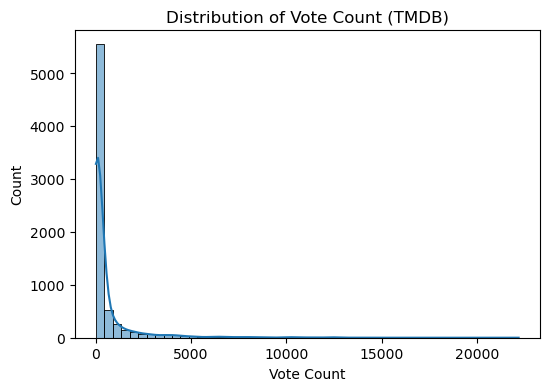

count     7103.000000
mean       601.322540
std       1625.532402
min          1.000000
50%         70.000000
75%        344.500000
90%       1501.800000
95%       3240.000000
99%       8712.120000
max      22186.000000
Name: vote_count, dtype: float64


In [67]:

plt.figure(figsize=(6,4))
sns.histplot(combined_df['vote_count'], bins=50, kde=True)
#plt.xscale('log')  # use log scale because vote counts are skewed
plt.title("Distribution of Vote Count (TMDB)")
plt.xlabel("Vote Count")
plt.show()
#Explain to self
print(combined_df['vote_count'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

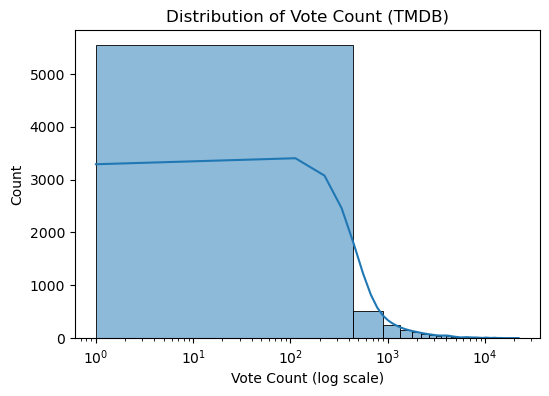

count     7103.000000
mean       601.322540
std       1625.532402
min          1.000000
50%         70.000000
75%        344.500000
90%       1501.800000
95%       3240.000000
99%       8712.120000
max      22186.000000
Name: vote_count, dtype: float64


In [68]:
#Logging it for better data

plt.figure(figsize=(6,4))
sns.histplot(combined_df['vote_count'], bins=50, kde=True)
plt.xscale('log')  # use log scale because vote counts are skewed
plt.title("Distribution of Vote Count (TMDB)")
plt.xlabel("Vote Count (log scale)")
plt.show()

print(combined_df['vote_count'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

In [69]:
#Filter data with less vote counts to avoid skewness
threshold = 100
df_filtered = combined_df[combined_df['vote_count'] >= threshold]
print(f"Movies retained after threshold: {len(df_filtered)} / {len(combined_df)}")

Movies retained after threshold: 3073 / 7103


In [70]:
# Top by popularity
top_popularity = df_filtered.sort_values('popularity', ascending=False).head(10)

# Top by IMDB average rating
top_imdb = df_filtered.sort_values('averagerating', ascending=False).head(10)

# Top by TMDB vote_average
top_tmdb = df_filtered.sort_values('vote_average', ascending=False).head(10)

# Top by vote_count
top_votes = df_filtered.sort_values('vote_count', ascending=False).head(10)

In [71]:
def display_top(df, col, n=10):
    return df[['title', 'release_year', col]].head(n)

print("Top 10 by Popularity")
print(display_top(top_popularity, 'popularity'))

print("\n Top 10 by IMDB Rating")
print(display_top(top_imdb, 'averagerating'))

print("\n Top 10 by TMDB Rating")
print(display_top(top_tmdb, 'vote_average'))

print("\n Top 10 by Vote Count")
print(display_top(top_votes, 'vote_count'))

Top 10 by Popularity
                                            title  release_year  popularity
5410                       Avengers: Infinity War          2018      80.773
4178                                    John Wick          2014      78.123
5756            Spider-Man: Into the Spider-Verse          2018      60.534
3370    The Hobbit: The Battle of the Five Armies          2014      53.783
138                                  The Avengers          2012      50.289
2685                      Guardians of the Galaxy          2014      49.606
2326                            Blade Runner 2049          2017      48.571
5382  Fantastic Beasts: The Crimes of Grindelwald          2018      48.508
6461                    Ralph Breaks the Internet          2018      48.057
3261                       Spider-Man: Homecoming          2017      46.775

 Top 10 by IMDB Rating
                                   title  release_year  averagerating
6173                O.J. Made in America         

In [72]:
# Set weight for votes
imdb_vote_weight = 1000 #Using IMDB threshold
tmdb_vote_weight = 100 #Using TMDB threshold

# Combined Score Formula
df_filtered.loc[:,'combined_score'] = (
    (df_filtered.loc[:,'averagerating'] * df_filtered.loc[:,'numvotes'] / imdb_vote_weight) +
    (df_filtered.loc[:,'vote_average'] * df_filtered.loc[:,'vote_count'] / tmdb_vote_weight)
)

/var/folders/nn/6v8sy6r911d4ly_fvkqm3r6c0000gn/T/ipykernel_10366/2055434991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:,'combined_score'] = (


In [80]:
top_combined = df_filtered.sort_values('combined_score', ascending=False)
top_combined[['title','release_year','genres','averagerating','numvotes','vote_average','vote_count','popularity','combined_score']]

,title,release_year,genres,averagerating,numvotes,vote_average,vote_count,popularity,combined_score
759,Inception,2010,"Action,Adventure,Sci-Fi",8.8,1841066.0,8.3,22186,27.920,18042.8188
717,The Dark Knight Rises,2012,"Action,Thriller",8.4,1387769.0,7.7,13933,26.220,12730.1006
119,Interstellar,2014,"Adventure,Drama,Sci-Fi",8.6,1299334.0,8.2,18597,28.440,12699.2264
2315,Django Unchained,2012,"Drama,Western",8.4,1211405.0,8.0,15725,21.260,11433.8020
138,The Avengers,2012,"Action,Adventure,Sci-Fi",8.1,1183655.0,7.6,19673,50.289,11082.7535
...,...,...,...,...,...,...,...,...,...
4679,The Veil,2016,"Action,Adventure,Sci-Fi",3.5,1236.0,4.6,188,9.148,12.9740
4863,#Horror,2015,"Crime,Drama,Horror",3.0,3092.0,3.3,102,6.099,12.6420
6450,Divorce French Style,2014,Comedy,6.2,1074.0,5.1,100,6.630,11.7588
3253,Back in the Day,2016,Comedy,5.1,1546.0,2.8,102,6.420,10.7406


In [81]:
# Split genres into separate rows
df_genres = top_combined.assign(genre=top_combined['genres'].str.split(',')).explode('genre')

# Most frequent genres in top winners
genre_counts = df_genres['genre'].value_counts()
print("Most common genres among top movies:\n", genre_counts)

# Average combined score per genre
genre_avg_score = df_genres.groupby('genre')['combined_score'].mean().dropna().sort_values(ascending=False)
print("\nAverage combined score by genre:\n", genre_avg_score)

Most common genres among top movies:
 genre
Drama          1682
Comedy         1001
Action          736
Thriller        611
Adventure       532
Crime           507
Horror          485
Romance         450
Mystery         296
Biography       266
Sci-Fi          240
Fantasy         225
Animation       185
Family          111
History         111
Documentary     105
Music            87
War              51
Sport            49
Western          18
Musical          15
News              3
Name: count, dtype: int64

Average combined score by genre:
 genre
Sci-Fi         1430.484573
Adventure      1279.810525
Western        1109.769389
Action         1019.542257
Musical         896.207793
Fantasy         889.715437
Animation       724.252599
Biography       634.665535
Family          618.907873
Mystery         607.008202
Crime           554.064061
Thriller        545.006046
Sport           536.760539
Comedy          514.646177
Drama           505.566896
History         499.522230
Music           4

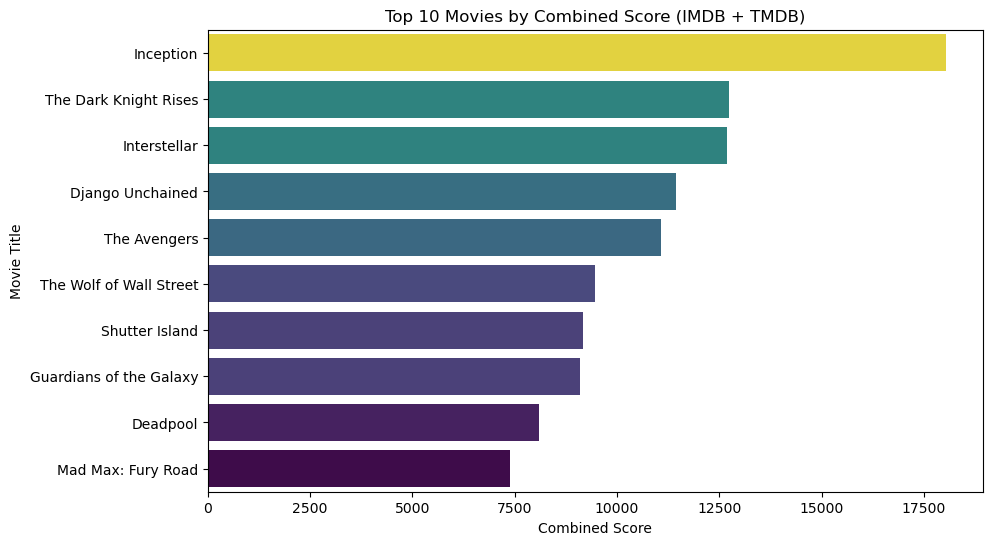

In [75]:
# Pick top 10 for clarity
top10_combined = top_combined.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x="combined_score", y="title", data=top10_combined, palette="viridis",hue="combined_score",legend=False)
plt.title("Top 10 Movies by Combined Score (IMDB + TMDB)")
plt.xlabel("Combined Score")
plt.ylabel("Movie Title")
plt.show()

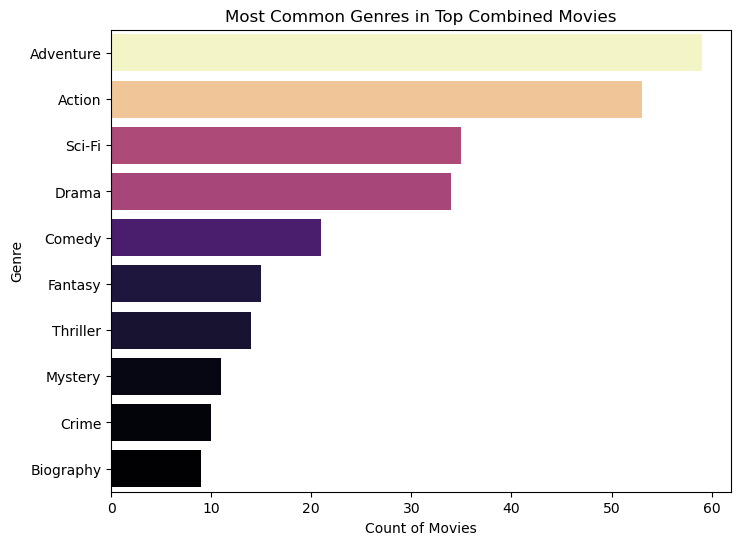

In [76]:
# Top 10 genres by frequency
plt.figure(figsize=(8,6))
sns.barplot(x=genre_counts.head(10).values, y=genre_counts.head(10).index,hue=genre_counts.head(10).values, palette="magma",legend=False)
plt.title( "Most Common Genres in Top Combined Movies")
plt.xlabel("Count of Movies")
plt.ylabel("Genre")
plt.show()

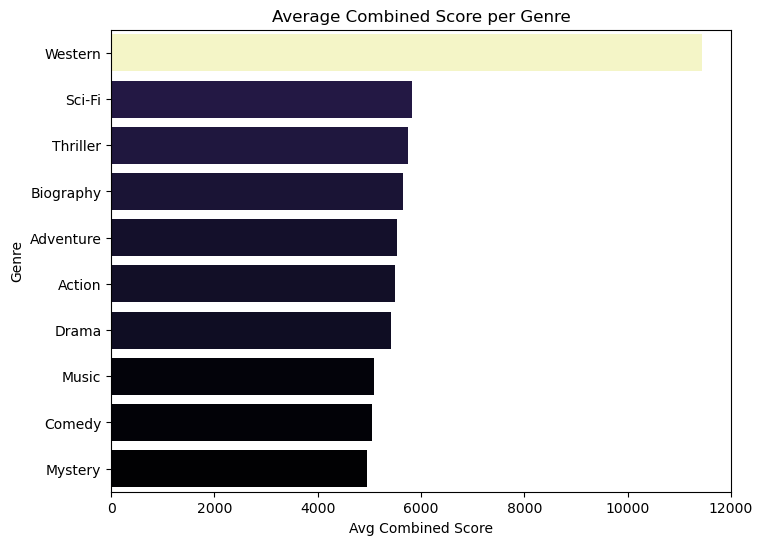

In [77]:
# Top 10 genres by average combined score
plt.figure(figsize=(8,6))
sns.barplot(x=genre_avg_score.head(10).values, y=genre_avg_score.head(10).index,hue=genre_avg_score.head(10).values, palette="magma",legend=False)
plt.title("Average Combined Score per Genre")
plt.xlabel("Avg Combined Score")
plt.ylabel("Genre")
plt.show()

In [1]:
top_combined.to_csv("combinedimdbtmdb.csv", index=False)

NameError: name 'top_combined' is not defined